In [1]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler


## Get Base Datasets

In [21]:
df = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals.csv")

# single_family_home_rentals = all_rentals[(all_rentals["Property Type"] == 6) & (all_rentals["Max Beds"] < 5) & (all_rentals["State"]).isin(["WA", "OR"])]

df = df[(df["Max Beds"] > 0 ) 
        & (df["Max Beds"] < 6)  
        & (df["Max Baths"] < 4)  
        & (df["Max Square Feet"] < 5000)  
        & (df["Max Rent Price"] < 10000)  
        & (df["State"].notna()) 
        & (df["Property Type"] == 6) 
        # & (df["State"]).isin(["TX"])
        ]

# df = df[~df['Address'].str.contains('Unit', case=False, na=False) & 
#         ~df['Address'].str.contains('Apt', case=False, na=False)]

df = df.rename(columns={
    'Max Square Feet': 'Square Feet',
    'Max Beds': 'Bedrooms',
    'Max Baths': 'Bathrooms',
    'Max Rent Price': 'Rent',
})

basic_metadata = ["Property ID", "Address"]

basic_features = ["Square Feet", "Bedrooms", "Bathrooms"]
target = "Rent"


## Get Median Income Dataset

In [22]:
#Get Median Income Data
median_income = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv", skiprows=[1], na_values='-')

median_income['GEO_ID'] = median_income['GEO_ID'].astype(str)

# Extracting everything after "US" and storing it in a new column 'cbg_geoid'
median_income['cbg_geoid'] = median_income['GEO_ID'].str.extract('US(\d+)')
median_income['median_income'] = median_income['B19013_001E'].str.replace(',','+').str.replace('+','').str.replace('-','').astype(float)

median_income = median_income[["cbg_geoid", "median_income" ]]

print(df["Property ID"].count())

df["cbg_geoid"] = df["cbg_geoid"].astype(str).str.split('.').str[0]
median_income["cbg_geoid"] = median_income["cbg_geoid"].astype(str)

df = df.merge(median_income, on='cbg_geoid', how="inner")

print(df["Property ID"].count())

51274
51273


## One Hot for Beds and Baths

In [4]:
columns_to_encode = ['Bedrooms', 'Bathrooms']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy variable trap

# Fit and transform the data
encoded_features = encoder.fit_transform(df[columns_to_encode])

# Get feature names for the encoded columns
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate the original DataFrame (excluding the original columns) with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

one_hot_features = encoded_feature_names.tolist()

## KNN Benchmark

In [5]:
import joblib

knn_features = ["Latitude", "Longitude"]
target = 'Rent'

# List of different n values
n_values = [1, 5, 10]

# Convert latitude and longitude from degrees to radians for haversine metric
df_rad = np.radians(df[knn_features].values)

# Loop over different values of n
for n in n_values:
    # Create a new column for the benchmark rent for each n
    column_name = f'Rent_Benchmark_{n}_neighbors'
    df[column_name] = np.nan
    
    # Drop rows with missing values in the knn_features or target columns
    knn_df = df[knn_features + [target]].dropna()
    
    # Extract feature values and target values
    X = knn_df[knn_features].values
    y = knn_df[target].values
    
    # Convert latitude and longitude from degrees to radians for haversine metric
    X_rad = np.radians(X)
    
    # Initialize the KNeighborsRegressor with the haversine metric
    knn = KNeighborsRegressor(n_neighbors=n, metric='haversine')
    
    # Fit the KNN model
    knn.fit(X_rad, y)
    
    joblib.dump(knn, fr'C:\Users\mattl\OneDrive\Desktop\Projects\stoebebirch\Models\knn_model_{n}_neighbors.pkl')


    # Predict the average rent for each point in the original DataFrame
    df[column_name] = knn.predict(df_rad)

# Display the first few rows of the DataFrame with the new columns
benchmark_features = [f'Rent_Benchmark_{n}_neighbors' for n in n_values]

display(df[benchmark_features].head())

,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors
0,1000.0,1025.0,1305.0
1,1050.0,1030.0,1305.0
2,2500.0,1325.0,1305.0
3,1000.0,1035.0,1305.0
4,1050.0,1030.0,1305.0


## Rescale Features

In [7]:
potential_features = ["median_income"] + one_hot_features + basic_features + benchmark_features

print(len(potential_features))

clean_df = df[basic_metadata + potential_features + [target]].dropna()

# display(clean_df)
# display(potential_features)

X_train, X_test, y_train, y_test = train_test_split(clean_df[potential_features], clean_df[[target]], train_size = .8, random_state=27)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.fit_transform(X_test)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

17


## Can we add Polynominals and Interactions

In [8]:
# only going to to leads to 324 Features. Up another level goes farther to like 9K
poly = PolynomialFeatures(degree = 2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)

X_test_poly = poly.transform(X_test_scaled)

print("X_Train.shape: {}".format(X_train_scaled.shape))

print("X_Train_poly.shape: {}".format(X_train_poly.shape))


X_Train.shape: (39271, 17)
X_Train_poly.shape: (39271, 170)


In [9]:
from sklearn.linear_model import Ridge, Lasso 

lr = LinearRegression().fit(X_train_scaled, y_train)
print("Linear Regression Score without Interations: {}".format(lr.score(X_test_scaled, y_test)))

lr_interactions = LinearRegression().fit(X_train_poly, y_train)
print("Linear Regression Score with Interations: {}".format(lr_interactions.score(X_test_poly, y_test)))

ridge = Ridge().fit(X_train_scaled, y_train)
print("Ridge Score without Interations: {}".format(ridge.score(X_test_scaled, y_test)))

ridge_interactions = Ridge().fit(X_train_poly, y_train)
print("Ridge Score with Interations: {}".format(ridge_interactions.score(X_test_poly, y_test)))

lasso = Lasso().fit(X_train_scaled, y_train)
print("Lasso Score without Interactions: {}".format(lasso.score(X_test_scaled, y_test)))

lasso_interactions = Lasso().fit(X_train_poly, y_train)
print("Lasso Score with Interations: {}".format(lasso_interactions.score(X_test_poly, y_test)))

#Too Slow
# rf = RandomForestRegressor().fit(X_train_scaled, y_train)
# print("Random Forrest Score without Interactions: {}".format(rf.score(X_test_scaled, y_test)))

# Too Slow
# rf_int = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
# print("Random Forrest Score with Interations: {}".format(rf_int.score(X_test_poly, y_test)))


Linear Regression Score without Interations: 0.9676132729902445
Linear Regression Score with Interations: -7.487367541618624e+20
Ridge Score without Interations: 0.967417603993942
Ridge Score with Interations: 0.9753293468000703
Lasso Score without Interactions: 0.9672715679150699
Lasso Score with Interations: 0.9694487250556888


## Explore Ridge With Interactions More

In [10]:
ridge_interactions = Ridge().fit(X_train_poly, y_train)


y_train_pred = ridge_interactions.predict(X_train_poly)

y_test_pred = ridge_interactions.predict(X_test_poly)

X_combined = pd.concat([X_train, X_test])
y_combined_pred = np.concatenate([y_train_pred, y_test_pred])
train_flag_combined = np.concatenate([np.ones(len(X_train)), np.zeros(len(X_test))])



42.361553340356345
0.9753293468000703


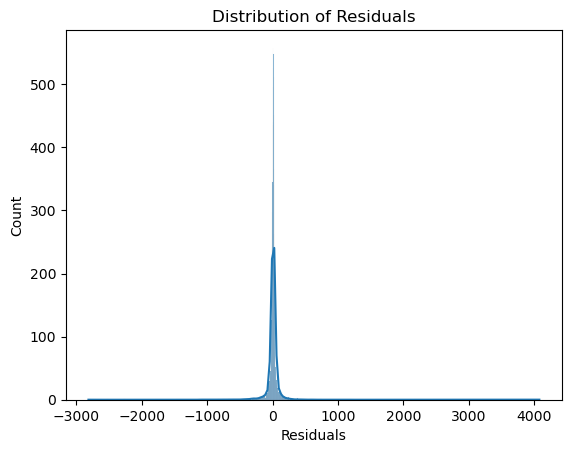

In [11]:
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(mae)
print(r2)

residuals = y_test_pred - y_test

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


## Feature Selection with Recursive Feature Eliminiation with Cross Val

In [12]:
from sklearn.feature_selection import RFECV

ridge = Ridge()

# Initialize RFECV with the Ridge model
rfecv = RFECV(estimator=ridge, step=1, cv=5, scoring='r2')

# Fit RFECV
rfecv.fit(X_train_poly, y_train)

# Number of features selected
print("Optimal number of features: %d" % rfecv.n_features_)


Optimal number of features: 123


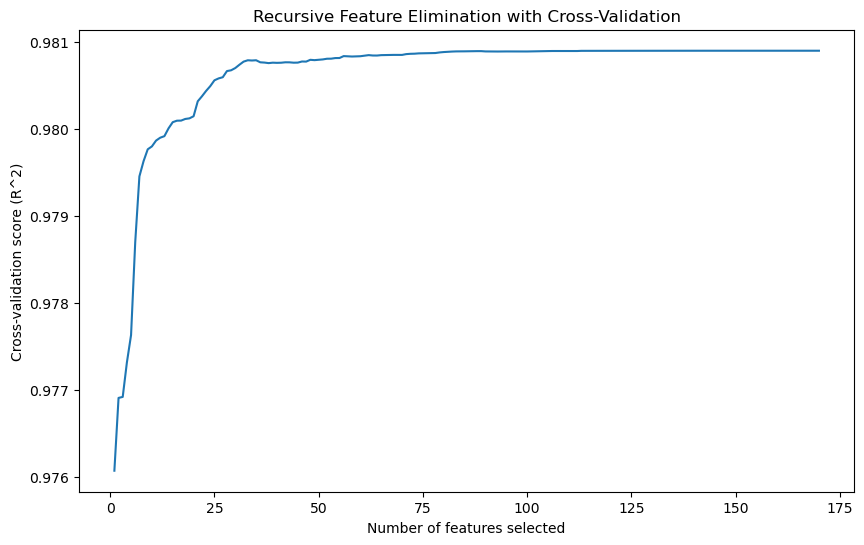

Selected features: ['median_income', 'Bedrooms_3', 'Bedrooms_4', 'Bedrooms_5', 'Bathrooms_1.0', 'Bathrooms_1.5', 'Bathrooms_2.0', 'Bathrooms_2.5', 'Bathrooms_3.0', 'Square Feet', 'Bedrooms', 'Bathrooms', 'Rent_Benchmark_1_neighbors', 'Rent_Benchmark_5_neighbors', 'Rent_Benchmark_10_neighbors', 'median_income^2', 'median_income Bedrooms_2', 'median_income Bedrooms_3', 'median_income Bedrooms_4', 'median_income Bedrooms_5', 'median_income Bathrooms_1.5', 'median_income Bathrooms_2.0', 'median_income Bathrooms_2.5', 'median_income Bathrooms_3.0', 'median_income Bathrooms_3.5', 'median_income Bedrooms', 'median_income Bathrooms', 'median_income Rent_Benchmark_1_neighbors', 'median_income Rent_Benchmark_5_neighbors', 'median_income Rent_Benchmark_10_neighbors', 'Bedrooms_2 Bathrooms_1.0', 'Bedrooms_2 Bathrooms_1.5', 'Bedrooms_2 Bathrooms_2.0', 'Bedrooms_2 Bathrooms_2.5', 'Bedrooms_2 Bathrooms_3.0', 'Bedrooms_2 Square Feet', 'Bedrooms_2 Bathrooms', 'Bedrooms_2 Rent_Benchmark_1_neighbors', 'B

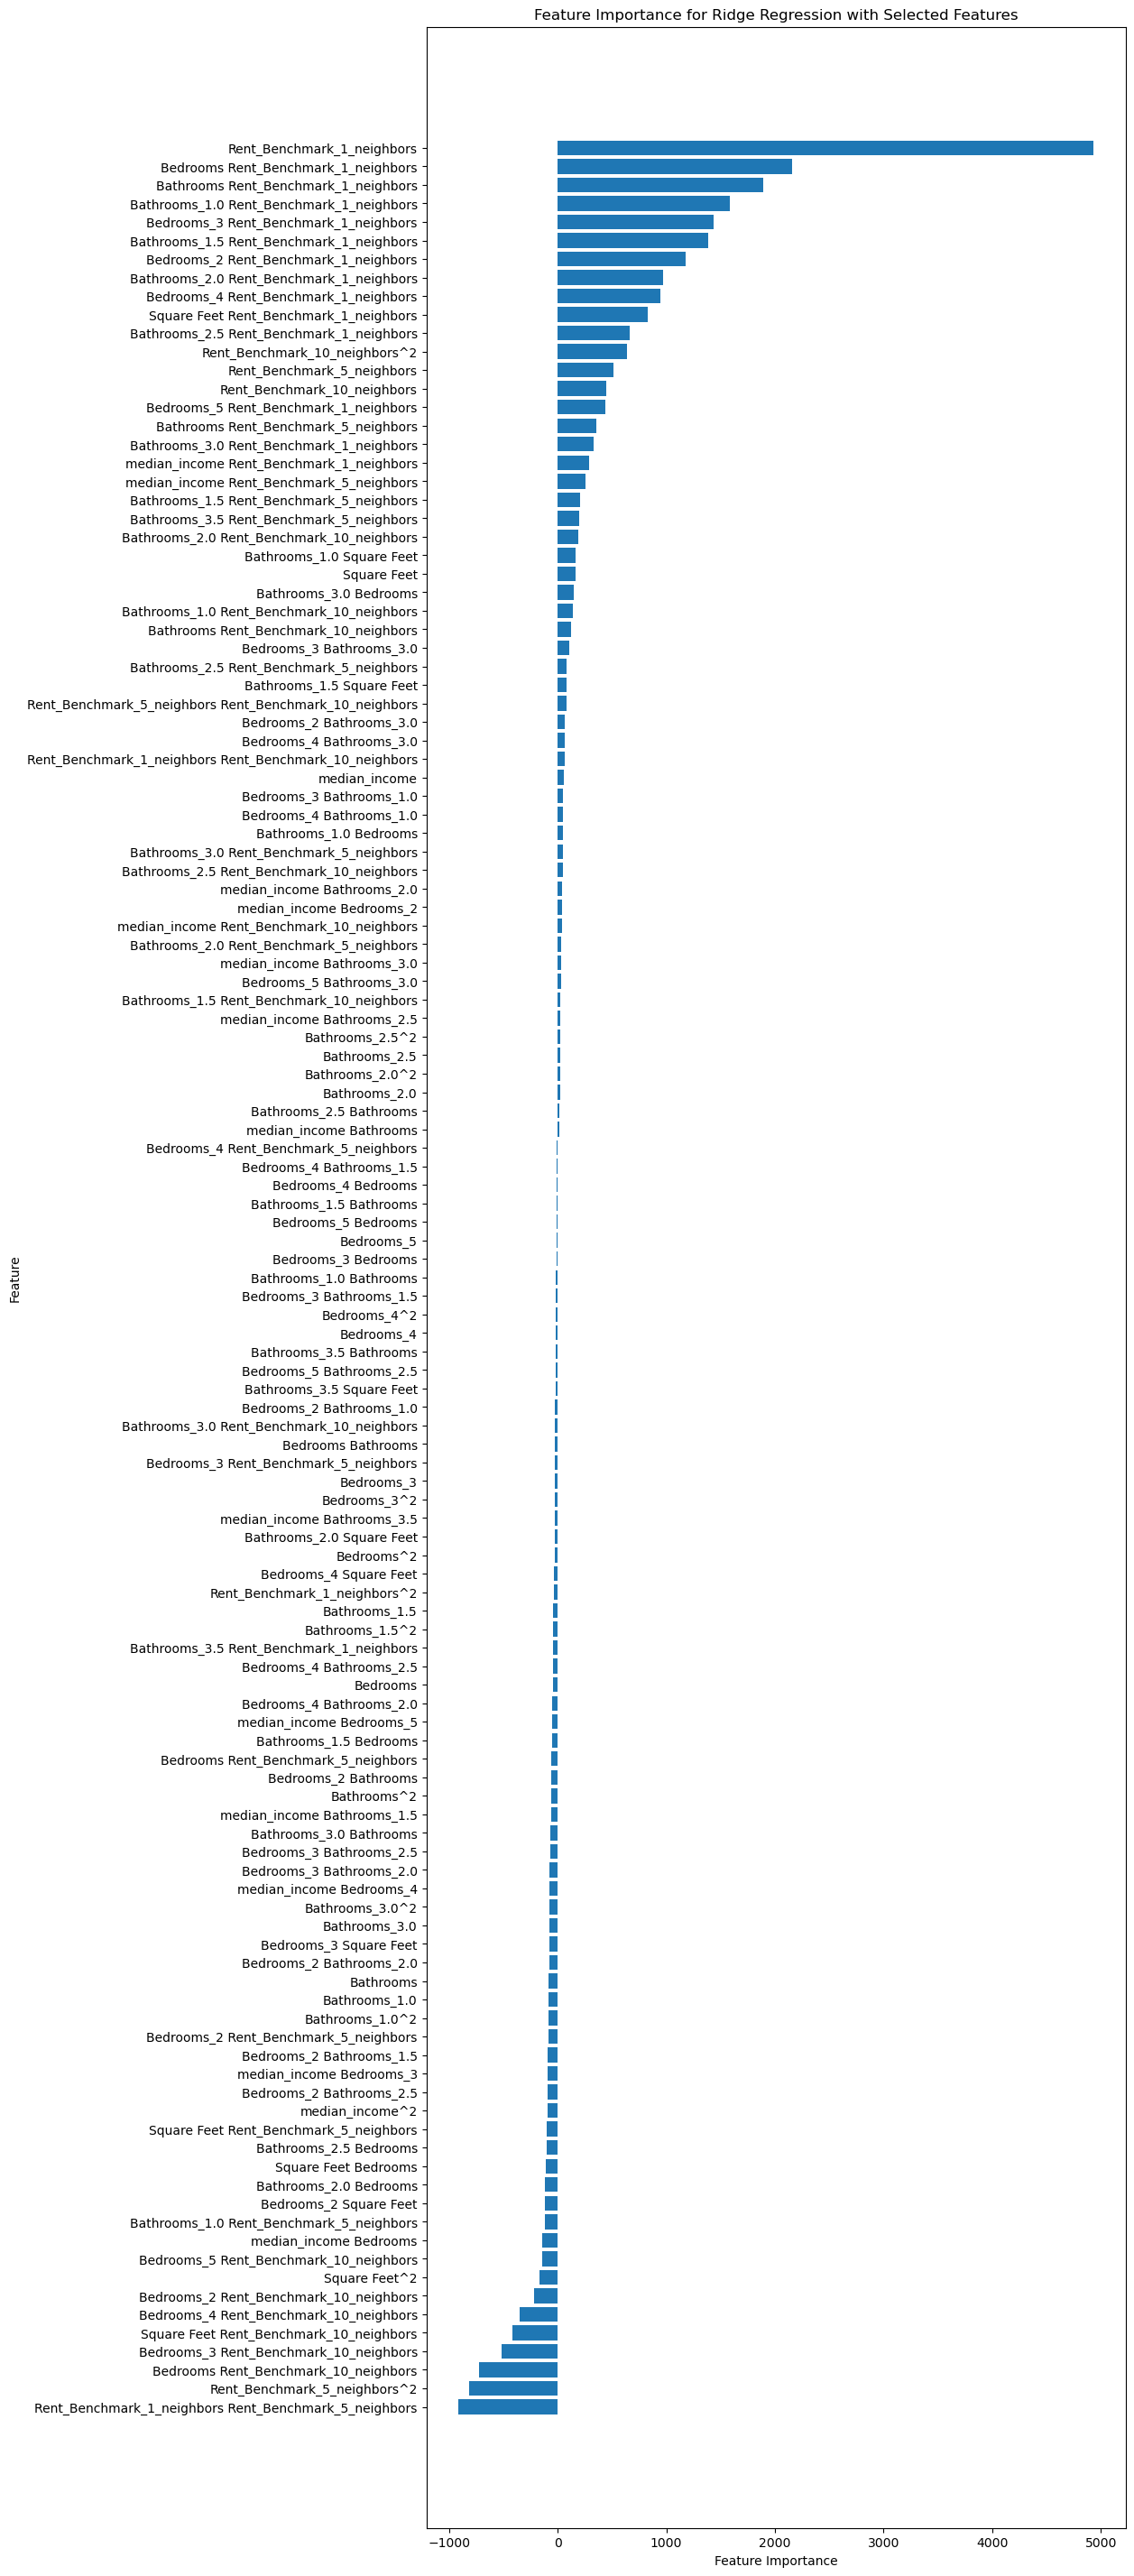

In [13]:

# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score (R^2)')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Get the selected features mask
selected_features_mask = rfecv.support_

# Get the feature names
feature_names = poly.get_feature_names_out(potential_features)

# Get the selected features
selected_features = [feature for feature, selected in zip(feature_names, selected_features_mask) if selected]

# Print the selected features
print("Selected features:", selected_features)

# Transform the training and test sets to the optimal feature set
X_train_selected = rfecv.transform(X_train_poly)
X_test_selected = rfecv.transform(X_test_poly)

# Refit the model using the selected features
ridge.fit(X_train_selected, y_train)

# Evaluate the model
train_score = ridge.score(X_train_selected, y_train)
test_score = ridge.score(X_test_selected, y_test)

print("Train R^2 score with selected features: {:.4f}".format(train_score))
print("Test R^2 score with selected features: {:.4f}".format(test_score))

feature_importances = ridge.coef_

# Create a DataFrame for the feature importances
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 36))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Ridge Regression with Selected Features')
plt.gca().invert_yaxis()
plt.show()

In [14]:

# Generate polynomial features for the entire dataset
X_scaled = scaler.transform(clean_df[potential_features])
X_poly = poly.transform(X_scaled)

# Select important features for the entire dataset
X_selected = rfecv.transform(X_poly)

# Create a new DataFrame with the original index and selected features
selected_feature_df = pd.DataFrame(X_selected, index=clean_df.index, columns=selected_features)

# Concatenate the new features with the original DataFrame
full_df = pd.concat([clean_df, selected_feature_df], axis=1)

# Display the new DataFrame
display(full_df)

,Property ID,Address,median_income,Bedrooms_2,Bedrooms_3,Bedrooms_4,Bedrooms_5,Bathrooms_1.0,Bathrooms_1.5,Bathrooms_2.0,...,Bathrooms^2,Bathrooms Rent_Benchmark_1_neighbors,Bathrooms Rent_Benchmark_5_neighbors,Bathrooms Rent_Benchmark_10_neighbors,Rent_Benchmark_1_neighbors^2,Rent_Benchmark_1_neighbors Rent_Benchmark_5_neighbors,Rent_Benchmark_1_neighbors Rent_Benchmark_10_neighbors,Rent_Benchmark_5_neighbors^2,Rent_Benchmark_5_neighbors Rent_Benchmark_10_neighbors,Rent_Benchmark_10_neighbors^2
0,191142853,1833 W Quinn Rd Unit B,73015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.000000,0.000000,0.000000,0.005778,0.004406,0.006443,0.003360,0.004913,0.007185
1,191136919,1821 W Quinn Rd Unit A,73015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.000000,0.000000,0.000000,0.006585,0.004758,0.006879,0.003438,0.004970,0.007185
2,174553230,1805 Brock Dr,73015.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.16,0.092039,0.039322,0.033905,0.052945,0.022620,0.019504,0.009664,0.008333,0.007185
3,191130680,1805 W Quinn Rd Unit A,73015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.000000,0.000000,0.000000,0.005778,0.004508,0.006443,0.003517,0.005027,0.007185
4,191130550,1809 W Quinn Rd Unit D,73015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.000000,0.000000,0.000000,0.006585,0.004758,0.006879,0.003438,0.004970,0.007185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51268,126484177,1125 W Pine St,65958.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.000000,0.000000,0.000000,0.028207,0.028413,0.025217,0.028621,0.025401,0.022544
51269,126567256,1516 Sunset Dr,49516.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.16,0.075603,0.068101,0.072578,0.035724,0.032179,0.034295,0.028986,0.030891,0.032922
51270,191143352,217 Marjorie Pl Unit 1,49516.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.16,0.063071,0.072835,0.076504,0.024863,0.028711,0.030157,0.033156,0.034826,0.036580
51271,114427052,1009 Chestnut St,45341.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.16,0.083821,0.064766,0.055012,0.043913,0.033930,0.028820,0.026216,0.022268,0.018914


In [15]:
selected_features = selected_feature_df.columns.tolist()

Linear Regression: Mean R^2 = -1937578780968336.0000, Std = 3674010751067970.0000
Ridge: Mean R^2 = 0.9804, Std = 0.0026
Lasso: Mean R^2 = 0.9775, Std = 0.0041


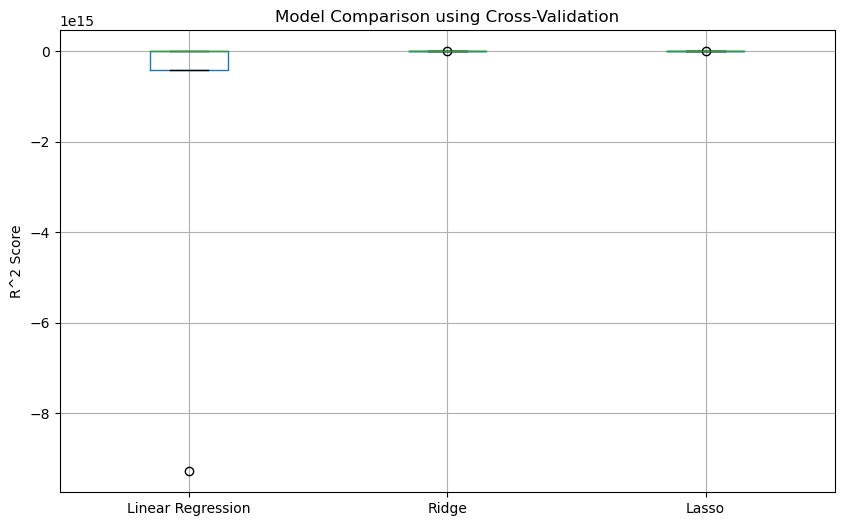

Best Model: Ridge
Test MAE: 34.1198
Test R^2: 0.9753


In [16]:
from sklearn.model_selection import cross_val_score


X_train_val, X_test, y_train_val, y_test = train_test_split(selected_feature_df, clean_df[[target]], train_size=0.8, random_state=27)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=27)


models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=27)
}

results = {}

for model_name, model in models.items(): 
    scores = cross_val_score(model, X_train, y_train, scoring = 'r2')
    results[model_name] = scores
    print(f"{model_name}: Mean R^2 = {scores.mean():.4f}, Std = {scores.std():.4f}")

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
results_df.boxplot()
plt.title('Model Comparison using Cross-Validation')
plt.ylabel('R^2 Score')
plt.show()

# Optionally, train the best model on the combined training and validation set and evaluate on the test set
best_model_name = max(results, key=lambda k: results[k].mean())
best_model = models[best_model_name]
best_model.fit(X_train_val, y_train_val)

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Best Model: {best_model_name}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

## Because Ridge is best, we do not need to have a validation datset for fine tuning

In [19]:
#Check against validation Dataset

X_train, X_test, y_train, y_test = train_test_split(selected_feature_df, clean_df[[target]], train_size=0.9, random_state=27)


linear_model = Ridge()

linear_model.fit(X_train, y_train)

linear_model.predict(X_test)

array([[ 976.08689965],
       [1995.92283325],
       [2007.95184305],
       ...,
       [2292.87326398],
       [3512.28255547],
       [4541.53749234]])

Cross-Validation R^2 Scores: [ 9.39353550e-01  9.94607293e-01 -6.78940604e+16  9.94184064e-01
 -2.91516991e+17]
Mean Cross-Validation R^2 Score: -71882210351518000.0000
Cross-Validated Mean Absolute Error: 1420414830.6336
Cross-Validated R^2 Score: -62499228516248672.0000
Final Model Mean Absolute Error: 36.9214
Final Model R^2 Score: 0.9807


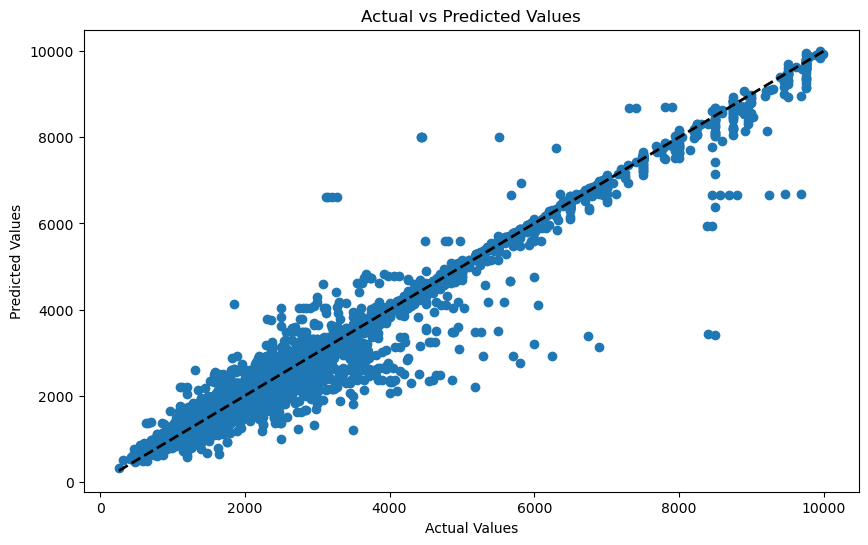

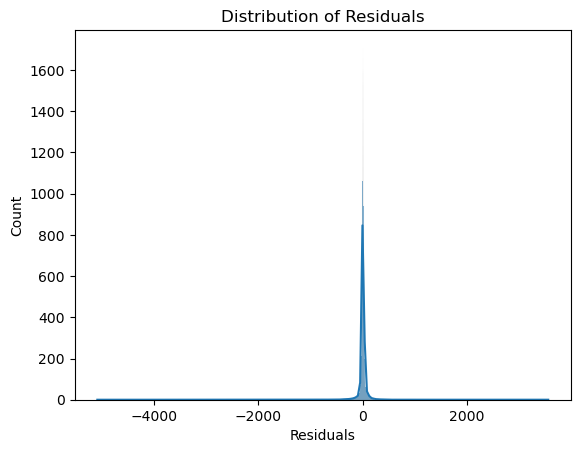

,Property ID,Address,median_income,Bedrooms_2,Bedrooms_3,Bedrooms_4,Bedrooms_5,Bathrooms_1.0,Bathrooms_1.5,Bathrooms_2.0,...,Bathrooms_3.0,Bathrooms_3.5,Square Feet,Bedrooms,Bathrooms,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors,Rent,Predicted_Rent
0,191142853,1833 W Quinn Rd Unit B,73015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1080.0,3,1.0,1000.0,1025.0,1305.0,1000.0,967.408752
1,191136919,1821 W Quinn Rd Unit A,73015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1080.0,3,1.0,1050.0,1030.0,1305.0,1050.0,1020.580872
2,174553230,1805 Brock Dr,73015.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1550.0,3,2.0,2500.0,1325.0,1305.0,2500.0,2511.273987
3,191130680,1805 W Quinn Rd Unit A,73015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1080.0,3,1.0,1000.0,1035.0,1305.0,1000.0,968.463501
4,191130550,1809 W Quinn Rd Unit D,73015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1080.0,3,1.0,1050.0,1030.0,1305.0,1050.0,1020.580872


In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Extract features and target variable
X = selected_feature_df
y = clean_df[target]

# Initialize the Linear Regression model
model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2 Score: {cv_scores.mean():.4f}")

# Get cross-validated predictions
cv_predictions = cross_val_predict(model, X, y, cv=5)

# Evaluate the model using cross-validated predictions
mae_cv = mean_absolute_error(y, cv_predictions)
r2_cv = r2_score(y, cv_predictions)

print(f"Cross-Validated Mean Absolute Error: {mae_cv:.4f}")
print(f"Cross-Validated R^2 Score: {r2_cv:.4f}")

# Train the final model on the entire dataset
model.fit(X, y)

# Make predictions on the entire dataset
predictions = model.predict(X)

# Add predictions to the original DataFrame
clean_df['Predicted_Rent'] = predictions

# Evaluate the final model
mae_final = mean_absolute_error(y, predictions)
r2_final = r2_score(y, predictions)

print(f"Final Model Mean Absolute Error: {mae_final:.4f}")
print(f"Final Model R^2 Score: {r2_final:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

# Visualize residuals
residuals = predictions - y
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

# Save the final model to a file
joblib.dump(model, 'single_family_rent_predictor.joblib')

# Display the DataFrame with the predictions
display(clean_df.head())


In [29]:
clean_df[basic_metadata + basic_features + ["median_income", "Rent", "Predicted_Rent"]].to_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals_with_predictions.csv")